# 데이터

In [1]:
import matplotlib.pyplot as plt
# pillow => 다양한 이미지 타입 지원
from PIL import Image

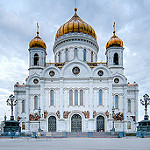

In [2]:
img = Image.open('/content/drive/MyDrive/데이터분석스쿨2기/share/12.데이터활용및과학방법론-12/res/torch_cnn_sample.png')
img

In [4]:
# pillow의 Image => numpy ndarray => tensor
import numpy as np

img_arr = np.array( img )
img_arr.shape # (h, w, c)

(150, 150, 3)

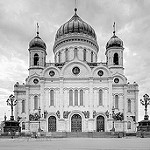

In [5]:
# 칼라이미지 => 그레이스케일  조정, 1채널
img = img.convert('L')
img

In [6]:
# 배열 변환
img_arr = np.array( img )
img_arr.shape

(150, 150)

array([[212, 213, 215, ..., 197, 199, 200],
       [215, 216, 216, ..., 197, 199, 200],
       [214, 215, 216, ..., 196, 197, 198],
       ...,
       [171, 171, 172, ..., 163, 166, 161],
       [174, 174, 174, ..., 173, 175, 168],
       [168, 168, 168, ..., 158, 159, 150]], dtype=uint8)
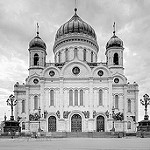

In [7]:
img_arr # 0 ~ 255 : 0 ~ 2^8-1

In [8]:
import torch

In [9]:
# 텐서로 변경
img_tensor = torch.Tensor( img_arr )
img_tensor

tensor([[212., 213., 215.,  ..., 197., 199., 200.],
        [215., 216., 216.,  ..., 197., 199., 200.],
        [214., 215., 216.,  ..., 196., 197., 198.],
        ...,
        [171., 171., 172.,  ..., 163., 166., 161.],
        [174., 174., 174.,  ..., 173., 175., 168.],
        [168., 168., 168.,  ..., 158., 159., 150.]])

In [11]:
# 기초점검, 형상, 타입, 최소, 최대, 차원수
img_tensor.size(), img_tensor.type(), img_tensor.min(), img_tensor.max(), img_tensor.dim()

(torch.Size([150, 150]), 'torch.FloatTensor', tensor(0.), tensor(255.), 2)

# 합성곱 직접 구현

- 원본 이미지
    - img_tensor

- 커널(필터)
    - k
    - 크기
        - (3,3)    
    - W
        - 가중치로 수직 성분 추출하는 용도
            - ver_kernal
        - 가중치로 수평 성분 추출하는 용도
            - hor_kernal
        - 2개의 가중치로 추출된 특징을 합치면 -> 간략하게 외곽선의 특징점을 추출하는 가중치 요소

- 패딩, 바이어스
    - 생략
- 스트라이드(stride)
    - 수직/수평 이동량 : 1
    - 이동방식 : z자


### 커널 준비

- 가중치를 부여한 채로 구성

In [12]:
# 수직 커널
# 라이트(빛)이 사물을 비출때 빛을 닫는 부분은 밝고, 반대쪽은 어둡다 => 이특징을 이용
ver_kernel = torch.Tensor([
    [ 1, 0, -1 ],
    [ 1, 0, -1 ],
    [ 1, 0, -1 ],
])
ver_kernel

tensor([[ 1.,  0., -1.],
        [ 1.,  0., -1.],
        [ 1.,  0., -1.]])

In [13]:
# 수평커널
hor_kernel = ver_kernel.T
hor_kernel

tensor([[ 1.,  1.,  1.],
        [ 0.,  0.,  0.],
        [-1., -1., -1.]])

### 스트라이드

In [14]:
stride = 1 # 수평, 수직 이동량 모두 1

### 합성곱상에서 특징 추출시 필요한 변수 지정

In [15]:
# 커널의 크기
k_h, k_w = ver_kernel.size()
k_h, k_w

(3, 3)

In [16]:
# 원본 이미지의 크기
img_h, img_w = img_tensor.size()
img_h, img_w

(150, 150)

### 커널 * 원본이미지(겹치는구간) 계산

In [20]:
# 커널이 이동중에 겹쳐진 원본이미지의 한부분 가정
target = torch.arange(9).view( (3,3) )
target

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])

In [22]:
# 특징 추출
torch.sum( target * ver_kernel )

tensor(-6.)

### 특징 추출 절차적 구현

In [26]:
# 1. 커널과 원본이미지가 겹치는 구간에서 연산 => 결과를 담는 그릇
final_buf = list() # feature map

# 실습 : 7분
# 2. 2회 반복을 통해서 원본이미지 상을 탐색 -> 연산 -> 결과를 그릇에 담는다
# 2-1 높이 기준 반복
for i in range( 0, img_h - k_h + 1, stride ):
    temp_buf = list() # 한줄 단위로 특징값을 담는다
    # 2-1-1 너비 기준 반복
    for j in range( 0, img_w - k_w + 1, stride ):
        # 2-1-1-1 커널이 원본이미지과 겹치는 구간 데이터 획득 = target
        img_target = img_tensor[ i:i+k_h , j:j+k_w ]
        # 2-1-1-2 torch.sum(커널 * target) -> 값 -> 버퍼(feature map)에 담는다
        temp_buf.append( torch.sum( img_target * ver_kernel ) )
        pass
    # 2-1-2 수평 단위 특징값을 담은 버퍼를 final_buf에 담음
    final_buf.append( temp_buf )

feature_map = torch.Tensor(final_buf)
feature_map.size()

torch.Size([148, 148])

In [27]:
feature_map

tensor([[ -6.,  -3.,   3.,  ...,  -8., -10.,  -8.],
        [ -6.,  -4.,  -1.,  ...,  -7.,  -7.,  -4.],
        [ -9., -10.,  -8.,  ...,  -3.,  -1.,   1.],
        ...,
        [  0.,   1.,   2.,  ...,   2.,  -1.,   5.],
        [ -1.,  -1.,   0.,  ...,   4.,   2.,   8.],
        [ -1.,  -2.,   0.,  ...,   4.,   6.,  15.]])

### 특징 추출 커스텀 함수 구성 (패딩배제)

In [32]:
def cus_convolution( x, kernel, stride=None ):
    '''
        - x : 원본 이미지(텐서)
        - kernel : 가중치를 파라미터로 가진 커널(가중치, 커널크기를 가진 형태의 텐서)
        - stride : 커널의 이동량
    '''
    if not stride:
        stride = (1,1)
    # 지역변수
    img_h, img_w = x.size()
    k_h, k_w     = kernel.size()
    s_h, s_w     = stride

    final_buf = list()
    for i in range( 0, img_h - k_h + 1, s_h ):
        temp_buf = list()
        for j in range( 0, img_w - k_w + 1, s_w ):
            img_target = img_tensor[ i:i+k_h , j:j+k_w ]
            temp_buf.append( torch.sum( img_target * kernel ) )
        final_buf.append( temp_buf )
    # 텐서 변환 및 반납
    return torch.Tensor( final_buf )

# 수직 성분을 추출하는 가중치를 가진 커널을 이용한 합성곱층 연산 구현
# 입력 => 원본이미지, 출력 => 수직성분이 특징으로 뽑힌 feature map|텐서
ver_feature_map = cus_convolution( img_tensor, ver_kernel, (1,1) )
ver_feature_map.size(), ver_feature_map

(torch.Size([148, 148]),
 tensor([[ -6.,  -3.,   3.,  ...,  -8., -10.,  -8.],
         [ -6.,  -4.,  -1.,  ...,  -7.,  -7.,  -4.],
         [ -9., -10.,  -8.,  ...,  -3.,  -1.,   1.],
         ...,
         [  0.,   1.,   2.,  ...,   2.,  -1.,   5.],
         [ -1.,  -1.,   0.,  ...,   4.,   2.,   8.],
         [ -1.,  -2.,   0.,  ...,   4.,   6.,  15.]]))

In [33]:
# 수평 성분을 가중치로 가진 커널을 이미지에 통과시켜서 수평 특징을 추출한 feature_map 추출
hor_feature_map = cus_convolution( img_tensor, hor_kernel, (1,1) )
hor_feature_map.size(), hor_feature_map

(torch.Size([148, 148]),
 tensor([[ -5.,  -4.,  -3.,  ...,   5.,   5.,   5.],
         [ 16.,  13.,   7.,  ...,   3.,   8.,  13.],
         [ 28.,  23.,  14.,  ...,   2.,   8.,  15.],
         ...,
         [-27., -30., -32.,  ...,  19.,  21.,  22.],
         [-42., -44., -46.,  ...,  -2.,   1.,   6.],
         [ 10.,  11.,  13.,  ...,  15.,  17.,  23.]]))

### 합성곱을 통과한 피처맵의 시각화

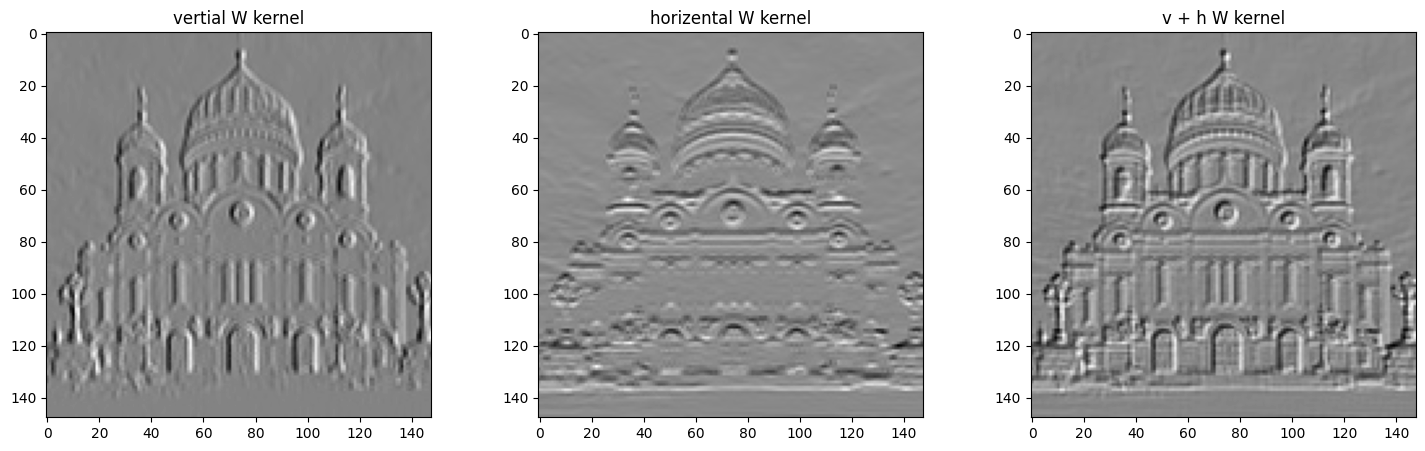

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots( 1, 3, figsize=((5+1)*3, 5))

# 수직
ax1.set_title('vertial W kernel')
ax1.imshow( ver_feature_map, cmap='binary' )

# 수평
ax2.set_title('horizental W kernel')
ax2.imshow( hor_feature_map, cmap='binary' )

# 수직+수평 => 외곽선이 더 도도라짐
ax3.set_title('v + h W kernel')
ax3.imshow( ver_feature_map+hor_feature_map, cmap='binary' )

plt.show()

- 빛의 방향은 오른쪽->왼쪽, 아래->위쪽 진행
- 경계선이 잘 보임
- 색상이 탁함
    - 색상값이 음수로 표현되는 부분에 문제
    - 음수는 0으로, 양수는 그대로 살려서 데이터를 보정
        - 활성화 함수를 통과시켜서 데이터를 전체적으로 조정
        - relu 적용

## feature map에 활성화 함수 통과 -> activatin map을 생성

- 색상값에는 원래 음수가 없다
    - 보정처리

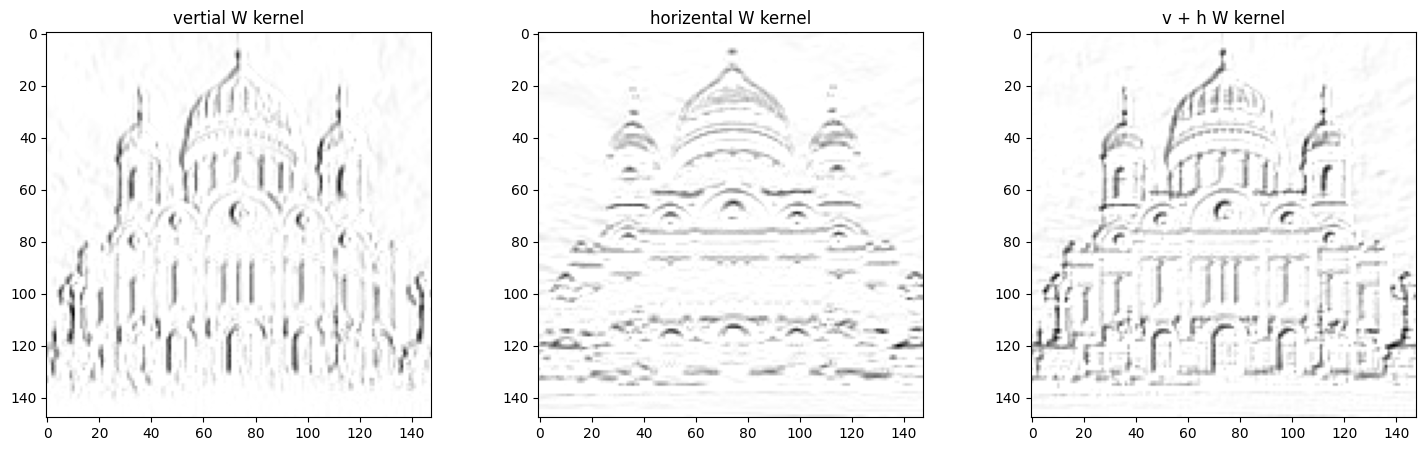

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots( 1, 3, figsize=((5+1)*3, 5))

# 수직
ax1.set_title('vertial W kernel')
ax1.imshow( torch.relu(ver_feature_map), cmap='binary' )

# 수평
ax2.set_title('horizental W kernel')
ax2.imshow( torch.relu(hor_feature_map), cmap='binary' )

# 수직+수평 => 외곽선이 더 도도라짐
ax3.set_title('v + h W kernel')
ax3.imshow( torch.relu(ver_feature_map+hor_feature_map), cmap='binary' )

plt.show()

# 음수(노이즈)를 제거한후 데이터
# 탁한 느낌은 제거

- 음수를 제거하여 원래 원본 이미지의 색상값들의 범위 유지
    - 단위 보정
- 흐려진 느낌은 남아 있다
    - 선명하게 보정할 필요가 있음 -> 윤곽이 잘보이게 보정 -> 특징 강화 -> 풀링으로 이동

## API를 이용하여 구현

In [39]:
# 커스텀 구성과 API 구성간 성능 체크 => 동일여부 검증
import torch.nn as nn

In [40]:
# 커스텀 구성과 동일한 옵션 사용
conv_layer = nn.Conv2d(
    in_channels  = 1,
    out_channels = 1,   # 채널을 늘리지 않음
    kernel_size  = 3,
    stride       = 1,
    bias         = False
)
conv_layer

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)

In [42]:
# 합성곱층이 생성되면 가중치가 내부적으로 생성 -> 4D로 구성됨
conv_layer.weight.data, conv_layer.weight.data.size()

(tensor([[[[-0.1990,  0.3221, -0.1826],
           [-0.1415,  0.0404,  0.1681],
           [ 0.0152, -0.0486, -0.1945]]]]),
 torch.Size([1, 1, 3, 3]))

In [44]:
ver_kernel.size(0)

3

In [46]:
# 가중치를 직접 만든 수직 혹은 수평 커널로 교체
# (3,3) => (1, 1, 3, 3)
# reshape, view, unsqueeze, expand(shape 확장용)
ver_kernel.expand( 1, 1, ver_kernel.size(0), ver_kernel.size(1)).size()

torch.Size([1, 1, 3, 3])

In [47]:
# 가중치 교체
conv_layer.weight.data = ver_kernel.expand( 1, 1,
                            ver_kernel.size(0), ver_kernel.size(1))
conv_layer.weight.data

tensor([[[[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]]]])

In [49]:
# 원본이미지를 conv_layer에 통과시킴
# 이미지 형식을 맞춰야함 -> NCHW -> channel_first
# (150, 150) -> (1, 1, 150, 150)
print( img_tensor.size() )
cur_img = img_tensor.expand( 1, 1, img_tensor.size(0), img_tensor.size(1) )
cur_img.size()

torch.Size([150, 150])


torch.Size([1, 1, 150, 150])

In [50]:
# cur_img( 원본이미지)를 conv_layer에 통과시킴
conv_feature_map = conv_layer( cur_img )
conv_feature_map.size()

torch.Size([1, 1, 148, 148])

In [52]:
# conv_feature_map, ver_feature_map 둘사이 동일한지 체크
# conv_feature_map == ver_feature_map 체크 => 실습 1분, size() 맞춰야함
conv_feature_map == ver_feature_map
conv_feature_map.squeeze() == ver_feature_map

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [53]:
# 커스텀 구현 혹은 API 의 결과물은 동일(성능차이및 기능 제한만 차이남)
torch.sum( conv_feature_map.squeeze() == ver_feature_map )

tensor(21904)

In [54]:
148*148

21904

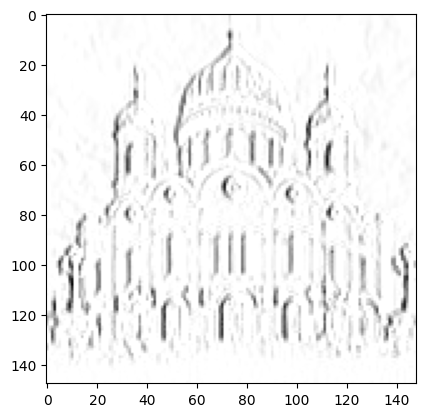

In [56]:
# API를 이용한 결과를 화면에 출력
# API -> 인공신경망구성의 요소 사용 -> 최적화를 위한 장치가 같이 적용
# 오차역전파를 처리를 하기 위해서는 미분 처리가 적용 -> 기록, 락등이 걸려있다
# 중간 확인(훈련중에) -> 락해제(detach()) -> 업무 -> 다시 락잠금(자동 혹은 수동)
plt.imshow( torch.relu( conv_feature_map.squeeze() ).detach().numpy()
            , cmap='binary' )
plt.show()

## 합성곱 요인(성분)들간에 관계식

- 합성곱층을 통과한 데이터의 shape을 계산할수 있음
- 성분
    - k : 커널
    - s : 스트라이드
    - p : 패딩
    - h : 이미지 높이
    - w : 이미지 너비
- 관계식

```
      h' = ( (h+2*p-k) / s) + 1
         = ( (150+2*0-3) / 1) + 1
         = ( (150-3) / 1) + 1
         = ( 147 / 1) + 1
         = 147 + 1
         = 148
```

# 최대 풀링 직접 구현

## 기본

- 풀링
    - 최대풀링
    - 커널과 원본데이터가 겹치는 구간에서 최대값 획득
        - max()
    - 가중치 X, 편향 X

In [57]:
# 활성화맵에서부터 출발
activation_map = torch.relu( ver_feature_map )
activation_map

tensor([[ 0.,  0.,  3.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  1.],
        ...,
        [ 0.,  1.,  2.,  ...,  2.,  0.,  5.],
        [ 0.,  0.,  0.,  ...,  4.,  2.,  8.],
        [ 0.,  0.,  0.,  ...,  4.,  6., 15.]])

In [59]:
# 활성화맵-> 최대풀링 처리 -> 커널사이즈, 이동량 => 동일하게 구성할수 있음
# 커널 크기
kernal_size = 2
# 스트라이드 양
stride_size = kernal_size
# ( (148+2*0-2) / 2) + 1
# (148, 148) -> ( 74, 74 ) 절반으로 크기 조절

## 최대값의 대상이 되는 원소들 모으기




- 시간 복잡도
    - 반복문 2회 -> O(N^2) 구현 가능함
    - 반복문을 최대로 줄인다(가급적 사용 X)
        - 원소(대상값들) 모으기
        - unfold() 활용

### unfold()

In [61]:
tmp = torch.arange(16).view( 1, 1, 4, 4 )
tmp.size(), tmp

(torch.Size([1, 1, 4, 4]),
 tensor([[[[ 0,  1,  2,  3],
           [ 4,  5,  6,  7],
           [ 8,  9, 10, 11],
           [12, 13, 14, 15]]]]))

In [62]:
'''
    - demension : 어떤 차원을 대상으로 펼칠것인가
    - size : 펼칠때 몇개씩 묶을 것인가?
    - step : 얼마 간격으로 떨어져서 처리
'''
tmp.unfold(2, 2, 2), tmp.unfold(2, 2, 2).size()

(tensor([[[[[ 0,  4],
            [ 1,  5],
            [ 2,  6],
            [ 3,  7]],
 
           [[ 8, 12],
            [ 9, 13],
            [10, 14],
            [11, 15]]]]]),
 torch.Size([1, 1, 2, 4, 2]))

In [63]:
# 최대값을 구해야할 원소간에 그룹으로 보임
tmp.unfold(2, 2, 2).unfold(3, 2, 2), tmp.unfold(2, 2, 2).unfold(3, 2, 2).size()

(tensor([[[[[[ 0,  1],
             [ 4,  5]],
 
            [[ 2,  3],
             [ 6,  7]]],
 
 
           [[[ 8,  9],
             [12, 13]],
 
            [[10, 11],
             [14, 15]]]]]]),
 torch.Size([1, 1, 2, 2, 2, 2]))

In [67]:
# 대상간 최대값 획득
# max(-1) -> 각 그룹의 최대갑 획득 -> [0]번 => 값, [1] => 최대값의 위치값
# 차원이 1개 줄어든다
tmp.unfold(2, 2, 2).unfold(3, 2, 2).max(-1)[0], tmp.unfold(2, 2, 2).unfold(3, 2, 2).max(-1)[0].size()

(tensor([[[[[ 1,  5],
            [ 3,  7]],
 
           [[ 9, 13],
            [11, 15]]]]]),
 torch.Size([1, 1, 2, 2, 2]))

In [68]:
# 최대 풀링 완성
# 차원을 분해하여 차원을 증가 -> 최대값을 구하는 대상끼리 묶여지면 -> 최대값 -> 차원줄임 -> ... -> 완료
tmp.unfold(2, 2, 2).unfold(3, 2, 2).max(-1)[0].max(-1)[0]

tensor([[[[ 5,  7],
          [13, 15]]]])

In [69]:
# 데이터 형식 조정
h, w = activation_map.size()
activation_map_4d = activation_map.expand( 1, 1, h, w )
activation_map_4d.size()

torch.Size([1, 1, 148, 148])

## 직접구현

In [70]:
# 함수
def cus_max_pooling( x, kernal_size, stride_size=None ):
    # 실습 3분
    if not stride_size:
        stride_size = kernal_size
    return x.unfold(2, kernal_size, stride_size).unfold(3, kernal_size, stride_size).max(-1)[0].max(-1)[0]
    pass

max_pool_map = cus_max_pooling( activation_map_4d, kernal_size )
max_pool_map.size()

torch.Size([1, 1, 74, 74])

## API 이용

In [71]:
maxpooling_layer = nn.MaxPool2d(kernal_size)

In [72]:
activation_map_4d_api = maxpooling_layer( activation_map_4d )
activation_map_4d_api.size()

torch.Size([1, 1, 74, 74])

In [73]:
# 직접 구현과 api 구현의 결과물 동일함
torch.sum( max_pool_map == activation_map_4d_api ), 74*74

(tensor(5476), 5476)

## 시각화(특징 강화 확인)

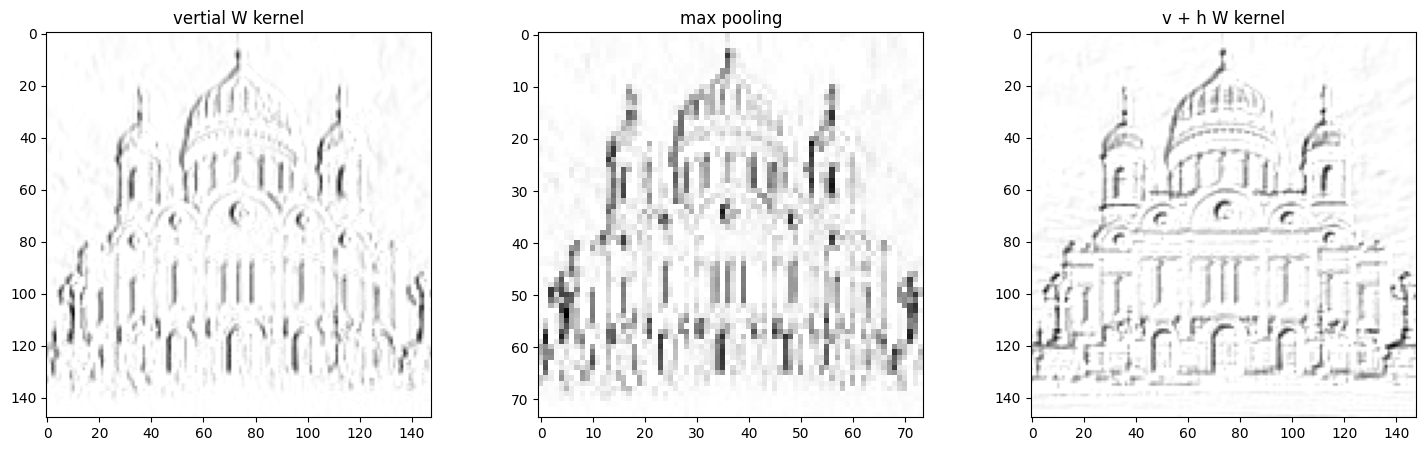

In [75]:
fig, (ax1, ax2, ax3) = plt.subplots( 1, 3, figsize=((5+1)*3, 5))

# 합성곱층 통과후 데이터
ax1.set_title('vertial W kernel')
ax1.imshow( torch.relu(ver_feature_map), cmap='binary' )

# api 진행된 최대풀링 결과문
ax2.set_title('max pooling')
ax2.imshow( torch.relu(activation_map_4d_api.squeeze()).detach().numpy(), cmap='binary' )

# 수직+수평 => 외곽선이 더 도도라짐
ax3.set_title('v + h W kernel')
ax3.imshow( torch.relu(ver_feature_map+hor_feature_map), cmap='binary' )

plt.show()

# 특징강화 -> 수직성분만 -> 강화
# 수직+수평 -> 특징강화가 더 나을듯
# 풀링 이미지가 깨져 보이는 이유 => 이미지 크기가 절반으로 줄어들어서 생기는 요인